In [6]:
import numpy as np
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import os
import sys
sys.path.append("..")
from common_functions import HSV_features_generation

KeyError: "Registering two gradient with name 'ArgMax'! (Previous registration was in register d:\\Programmes\\miniconda3\\envs\\env_master_project\\lib\\site-packages\\tensorflow\\python\\framework\\registry.py:65)"

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

def eval_decision_tree(X,y,max_depth,k,min_samples_split=2, min_samples_leaf=1,show_tree=False):
    # Initialize a list to store the accuracy scores
    accuracy_scores = []
    val_accuracy_scores = []
    test_accuracy_scores = []
    features_weights = []
    confusion_matrixs = []
    val_confusion_matrixs = []
    test_confusion_matrixs = []


    # Créer une instance de StratifiedKFold avec k plis
    skf = StratifiedKFold(n_splits=k)

    for i, (train_index, val_test_index) in enumerate(skf.split(X, y)):
        if(show_tree):
            print(f"Fold {i}:")
        # Spécifie les données d'entrainement
        X_train = X.iloc[train_index]
        y_train = y[train_index]

        # Spécifie les données de validation et de test
        skf2 = StratifiedKFold(n_splits=2)
        test_index,val_index = next(skf2.split(X.iloc[val_test_index], y[val_test_index]))
        X_val = X.iloc[val_test_index].iloc[val_index]
        y_val = y[val_test_index][val_index]
        X_test = X.iloc[val_test_index].iloc[test_index]
        y_test = y[val_test_index][test_index]

        # Création de l'arbre de décision
        decision_tree = DecisionTreeClassifier(random_state=0, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        
        # Entraînement de l'arbre de décision
        decision_tree.fit(X_train, y_train)

        y_train_pred = decision_tree.predict(X_train)
        y_val_pred = decision_tree.predict(X_val)
        y_test_pred = decision_tree.predict(X_test)

        # Calculate the accuracy score
        accuracy = metrics.accuracy_score(y_train, y_train_pred)
        val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
        test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

        confusion_mat = confusion_matrix(y_train, y_train_pred)
        confusion_mat_val = confusion_matrix(y_val, y_val_pred)
        confusion_mat_test = confusion_matrix(y_test, y_test_pred)

        if(show_tree):
            print(f'Fold {i} accuracy : {accuracy}, val accuracy :{val_accuracy},test accuracy :{test_accuracy}')

        # Append the accuracy score to the list
        accuracy_scores.append(accuracy)
        val_accuracy_scores.append(val_accuracy)
        test_accuracy_scores.append(test_accuracy)
        features_weights.append(decision_tree.feature_importances_) 
        confusion_matrixs.append(confusion_mat)
        val_confusion_matrixs.append(confusion_mat_val)
        test_confusion_matrixs.append(confusion_mat_test)

        if(show_tree):
            # Affichage des poids des caractéristiques
            print(f"Poids caractéristiques : {decision_tree.feature_importances_}")
            r = export_text(decision_tree, feature_names=X_train.columns.values.tolist())
            #Affichage arbre
            print(r,'\n')


    if(show_tree):
        # Compute the average accuracy across all folds
        print('-------------------')
        print(f"Train accuracy : {np.mean(accuracy_scores)}")
        print(f"Val accuracy : {np.mean(val_accuracy_scores)}")
        print(f"Test accuracy : {np.mean(test_accuracy_scores)}")
    features_weights = np.array(features_weights)
    average_weights = [features_weights[:,i].mean() for i in range(6)]
    if(show_tree):
        print('Average feature weights',average_weights)

    # Filtrer les poids et les noms des features pour exclure les valeurs nulles
    filtered_weights = [w for w in average_weights if w != 0]
    filtered_feature_names = [name for name, w in zip(['H_mean','H_std','S_mean','S_std','V_mean','V_std'], average_weights) if w != 0]
    if(show_tree):
        plt.pie(filtered_weights, labels=filtered_feature_names, autopct='%1.1f%%')
        plt.show()

        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlabel('Prédiction')
        ax.set_ylabel('Vraie étiquette')
        ax.set_title('Matrice de confusion')
        print('Average confusion matrix')
        sns.heatmap(np.mean(confusion_matrixs, axis=0), annot=True, cmap="Blues", ax=ax, fmt='.0f')
        plt.show()

        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlabel('Prédiction')
        ax.set_ylabel('Vraie étiquette')
        ax.set_title('Matrice de confusion val')
        print('Average val confusion matrix')
        sns.heatmap(np.mean(val_confusion_matrixs, axis=0), annot=True, cmap="Oranges", ax=ax, fmt='.0f')
        plt.show()

        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlabel('Prédiction')
        ax.set_ylabel('Vraie étiquette')
        ax.set_title('Matrice de confusion test')
        print('Average test confusion matrix')
        sns.heatmap(np.mean(test_confusion_matrixs, axis=0), annot=True, cmap="Greens", ax=ax, fmt='.0f')
        plt.show()

    return np.mean(accuracy_scores),np.mean(val_accuracy_scores),np.mean(test_accuracy_scores),np.array(average_weights)



In [3]:
#raw
X,y = HSV_features_generation('../images/raw_pollub/')


In [8]:
acc_train = []
acc_val = []
acc_test = []

for k in range(2,5+1):
    accuracies = []
    val_accuracies = []
    test_accuracies = []
    for max_depth in range(2,6+1):
        accuracy,val_accuracy,test_accuracy,features_weights = eval_decision_tree(X,y,max_depth,k)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
    acc_train.append(accuracies)
    acc_val.append(val_accuracies)
    acc_test.append(test_accuracies)



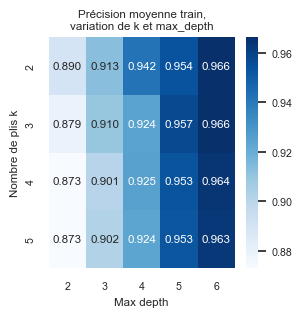

In [9]:
import seaborn as sns
sns.set(font_scale=0.7)
mat_acc_train = np.array(acc_train)
labels_x = range(2,7)
labels_y = range(2,6)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_train, annot=True, cmap="Blues", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Max depth')
plt.ylabel('Nombre de plis k')
plt.title('Précision moyenne train,\nvariation de k et max_depth')
plt.show()

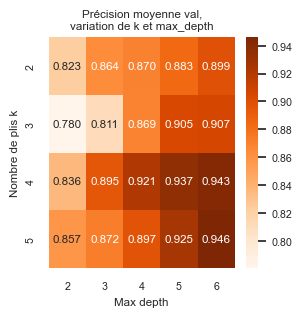

In [10]:
mat_acc_val = np.array(acc_val)
labels_x = range(2,7)
labels_y = range(2,6)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_val, annot=True, cmap="Oranges", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Max depth')
plt.ylabel('Nombre de plis k')
plt.title('Précision moyenne val,\nvariation de k et max_depth')
plt.show()

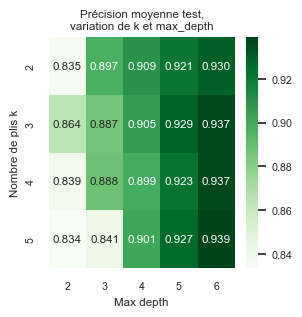

In [11]:
mat_acc_test = np.array(acc_test)
labels_x = range(2,7)
labels_y = range(2,6)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_test, annot=True, cmap="Greens", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Max depth')
plt.ylabel('Nombre de plis k')
plt.title('Précision moyenne test,\nvariation de k et max_depth')
plt.show()

In [31]:
acc_train = []
acc_val = []
acc_test = []
k = 5
max_depth = 6
for min_samples_split in range(2,20+1):
    accuracies = []
    val_accuracies = []
    test_accuracies = []
    for min_samples_leaf in range(1,20+1):
        accuracy,val_accuracy,test_accuracy,features_weights = eval_decision_tree(X,y,max_depth,k,min_samples_split,min_samples_leaf)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
    acc_train.append(accuracies)
    acc_val.append(val_accuracies)
    acc_test.append(test_accuracies)

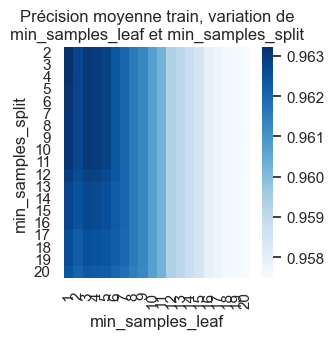

In [34]:
sns.set(font_scale=1)
mat_acc_train = np.array(acc_train)
labels_x = range(1,20+1)
labels_y = range(2,20+1)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_train,cmap="Blues", xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('min_samples_leaf')
plt.ylabel('min_samples_split')
plt.title('Précision moyenne train, variation de\nmin_samples_leaf et min_samples_split')
plt.show()

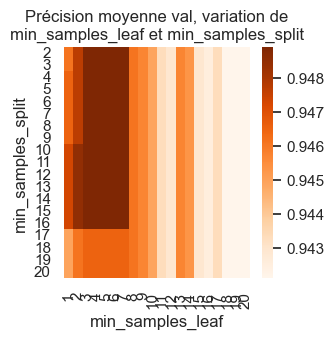

In [35]:
mat_acc_val = np.array(acc_val)
labels_x = range(1,20+1)
labels_y = range(2,20+1)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_val, cmap="Oranges", xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('min_samples_leaf')
plt.ylabel('min_samples_split')
plt.title('Précision moyenne val, variation de\nmin_samples_leaf et min_samples_split')
plt.show()

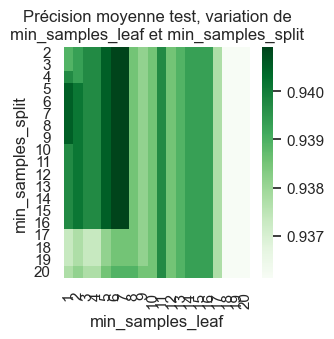

In [36]:
mat_acc_test = np.array(acc_test)
labels_x = range(1,20+1)
labels_y = range(2,20+1)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_test,cmap="Greens", xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('min_samples_leaf')
plt.ylabel('min_samples_split')
plt.title('Précision moyenne test, variation de\nmin_samples_leaf et min_samples_split')
plt.show()


Fold 0:
Fold 0 accuracy : 0.9608730369976045, val accuracy :0.9154704944178629,test accuracy :0.9712460063897763
Poids caractéristiques : [0.10927836 0.54871726 0.0643671  0.27505591 0.         0.00258137]
|--- H_std <= 39.91
|   |--- S_std <= 84.25
|   |   |--- H_mean <= 15.02
|   |   |   |--- S_std <= 83.46
|   |   |   |   |--- class: 2
|   |   |   |--- S_std >  83.46
|   |   |   |   |--- H_mean <= 14.82
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- H_mean >  14.82
|   |   |   |   |   |--- S_mean <= 142.07
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- S_mean >  142.07
|   |   |   |   |   |   |--- class: 2
|   |   |--- H_mean >  15.02
|   |   |   |--- H_std <= 34.78
|   |   |   |   |--- S_std <= 83.70
|   |   |   |   |   |--- S_std <= 83.52
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- S_std >  83.52
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- S_std >  83.70
|   |   |   |   |   |--- S_mean <= 142.28
|   |   |   |   |   |   |---

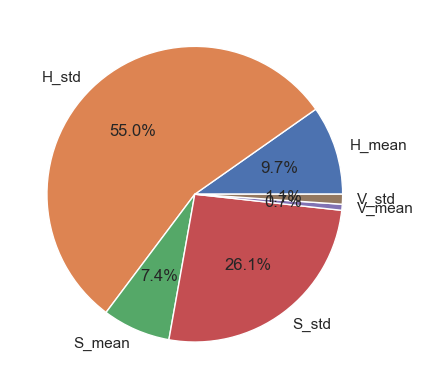

Average confusion matrix


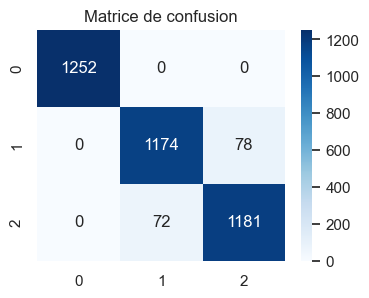

Average val confusion matrix


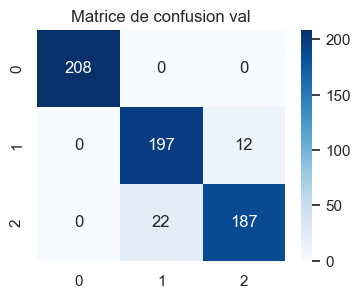

Average test confusion matrix


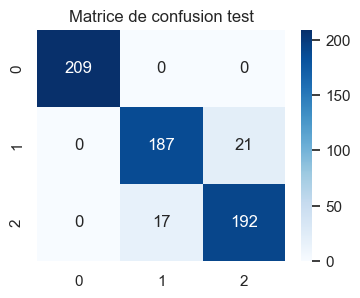

(0.960079609423063,
 0.9457384930522647,
 0.9388977635782747,
 array([0.09748071, 0.55003279, 0.07444436, 0.26065045, 0.00655691,
        0.01083478]))

In [44]:
eval_decision_tree(X,y,6,4,min_samples_split=2, min_samples_leaf=14,show_tree=True)